In [1]:
%store -r data_merged

# Packages and Basic information

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from sklearn import linear_model

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
data=data_merged.copy()
cc=data.country

In [6]:
data.drop(['day','ppl_km','country_code','urbanization','month','country','pop20','avg_age','deaths','recovered','active'],1,inplace=True)

In [7]:
#exponential growth implies a log transformation for the target variable

data['confirmed']=[np.log(x+1) for x in data.confirmed.values]

In [8]:
data.head()

,date_code,date,country_prov,confirmed
0,0,2020-01-22,China_Anhui,0.693147
1,0,2020-01-22,China_Beijing,2.708050
2,0,2020-01-22,China_Chongqing,1.945910
3,0,2020-01-22,China_Fujian,0.693147
4,0,2020-01-22,China_Gansu,0.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7900 entries, 0 to 7925
Data columns (total 4 columns):
date_code       7900 non-null int64
date            7900 non-null datetime64[ns]
country_prov    7900 non-null object
confirmed       7900 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 308.6+ KB


# Functions

1. **calculate_lag**: it allows to create temporal lags and store them into the dataset as features
2. **split_date**: splits data in testset and trainset with explanatory and target variables based on date.<br> *additional features*: <br>
    a. if requested, returns just train and test
    b. verbosity
    c. setting the dates to be in specific ranges (day_lim_min,day_lim_max)
3. **all_regression**: aggregative function; it allows to obtain the predictions. it is based on a loop cycle to let the test to be recomputed at each cycle with the new predicted lags
4. **country_plot**: it lets to plot predictions and real values

In [10]:
#split data based on the day (especially date_code)
def split_date(day_lim,df=data,target='confirmed',country='none', just_train=False,day_min=-1,day_max=-1):
    
    #utility to whether define country or not
    if country != 'none':
        df=df[df['country_prov']==country]
    else:
        pass
    
    train=df[df['date_code']<day_lim]
    test=df[df['date_code']>=day_lim]
    if day_min!=-1:
        train=train[train['date_code']>=day_min]
    if day_max!=-1:
        test=test[test['date_code']<=day_max]
    
    if just_train==True:
        return (train)
    else:
        train.drop(['country_prov'],1,inplace=True)
        test.drop(['country_prov'],1,inplace=True)
        #print('train and test shape:',train.shape,test.shape)

        X_train=train.drop([target],1)
        y_train=train[target]

        X_test=test.drop([target],1)
        y_test=test[target]
        return (X_train,y_train,X_test,y_test)

In [11]:
def lin_reg(X_train, Y_train, X_test):
    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)
    y_pred = regr.predict(X_test)
    return regr, y_pred


In [12]:
def all_regression( day_start,day_min=-1,day_max=-1 ,df=data, target='confirmed'):
    
    data2 = data.loc[data.date_code >= day_start]

    # Set the dataframe where we will update the predictions
    data_pred = data[['date','date_code','country_prov','confirmed']]
    data_pred = data_pred.loc[data_pred['date_code']>=day_start]
    data_pred['confirmed_pred'] = [0]*len(data_pred)
    data.drop(['date'],1,inplace=True)
    
    no_pred=[]
    # prediction for each country
    for c in data2['country_prov'].unique():
        print('country and province (if specified):',c)
        X_train,y_train,X_test,y_test = split_date(country=c,day_lim=day_start,target=target,day_min=day_min,day_max=day_max)
        if (X_train.shape[0]>1 and X_test.shape[0]>1) :
            model, pred = lin_reg(X_train, y_train, X_test)
            data_pred.loc[(data_pred['country_prov']==c), 'confirmed_pred'] = pred      
        else:
            print('************ too few data for predicting',c,'************')
            no_pred.append(c)
            pass

    # exponential
    data_pred[['confirmed_pred']] = np.around(data_pred[['confirmed_pred']].apply(lambda x: np.exp(x)+1))
    data_pred[['confirmed']]= np.around(data_pred[['confirmed']].apply(lambda x: np.exp(x)+1))
    data_pred.drop('date_code',1,inplace=True)
    return data_pred, no_pred


In [13]:
from datetime import datetime
import matplotlib.dates as mdates
def country_plot(df,title='ABC',x_size=20,y_size=6,split='2020-03-16',save_fig=False):
    s= datetime.strptime(split, '%Y-%m-%d')
    plt.figure(figsize=(x_size,y_size))

    x_values = df['date']
    y_values=df['real']
    z_values=df['predictions']

    plt.plot(x_values,z_values, 'g-',label='predictions')
    plt.plot(x_values,y_values, 'r-', label='real')
    plt.axvline(s, linestyle='--')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    if save_fig==True:
        plt.savefig(name +'-linear regression.png')
    return(plt.show())

------------------------------------

In [14]:
print(data.date_code.max(),data.date_code.min())

60 0


# Confirmed Predictions

#### define the day of start for reasearch

In [15]:
day=55

#### actual predictions

In [16]:
predictions, no_predictions=all_regression(day_start=day)

country and province (if specified): China_Hubei
country and province (if specified): Italy_
country and province (if specified): Iran_
country and province (if specified): Spain_
country and province (if specified): Germany_
country and province (if specified): South Korea_
country and province (if specified): France_France
country and province (if specified): Switzerland_
country and province (if specified): UK_United Kingdom
country and province (if specified): US_New York
country and province (if specified): Netherlands_Netherlands
************ too few data for predicting Netherlands_Netherlands ************
country and province (if specified): Norway_
country and province (if specified): China_Guangdong
country and province (if specified): Austria_
country and province (if specified): China_Henan
country and province (if specified): Belgium_
country and province (if specified): China_Zhejiang
country and province (if specified): Sweden_
country and province (if specified): US_Wash

country and province (if specified): US_Grand Princess
country and province (if specified): US_Mississippi
country and province (if specified): US_Nebraska
country and province (if specified): US_Arizona
country and province (if specified): US_Oklahoma
country and province (if specified): China_Qinghai
country and province (if specified): Guadeloupe_
country and province (if specified): US_Kansas
country and province (if specified): Martinique_
country and province (if specified): US_Delaware
country and province (if specified): Burkina Faso_
country and province (if specified): Ukraine_
country and province (if specified): Maldives_
country and province (if specified): Macao_Macao
country and province (if specified): Jamaica_
country and province (if specified): New Zealand_
country and province (if specified): US_Vermont
country and province (if specified): Bolivia_
country and province (if specified): French Guiana_
country and province (if specified): US_Missouri
country and provin

************ too few data for predicting Cabo Verde_ ************
country and province (if specified): Netherlands_Sint Maarten
************ too few data for predicting Netherlands_Sint Maarten ************
country and province (if specified): Niger_
************ too few data for predicting Niger_ ************
country and province (if specified): Papua New Guinea_
************ too few data for predicting Papua New Guinea_ ************
country and province (if specified): UK_Isle of Man
************ too few data for predicting UK_Isle of Man ************
country and province (if specified): Zimbabwe_
************ too few data for predicting Zimbabwe_ ************
country and province (if specified): Canada_Northwest Territories
************ too few data for predicting Canada_Northwest Territories ************
country and province (if specified): Timor-Leste_
************ too few data for predicting Timor-Leste_ ************
country and province (if specified): Eritrea_
************ too 

In [17]:
print('********************* country not predicted are',len(no_predictions), '********************* ')
for i in no_predictions:
    print(i)

********************* country not predicted are 51 ********************* 
Netherlands_Netherlands
France_Réunion
Canada_Nova Scotia
France_Guadeloupe
Guam_
Netherlands_Curaçao
Barbados_
Montenegro_
Benin_
Greenland_
Liberia_
Mayotte_
Somalia_
Tanzania_
Bahamas_
Gambia_
UK_Cayman Islands
Puerto Rico_
Palestine_
Kyrgyzstan_
Mauritius_
Netherlands_Aruba
US_United States Virgin Islands
Zambia_
Djibouti_
US_United States
UK_Montserrat
Denmark_Greenland
France_New Caledonia
UK_Bermuda
Chad_
El Salvador_
Fiji_
Nicaragua_
Madagascar_
Haiti_
Angola_
Cabo Verde_
Netherlands_Sint Maarten
Niger_
Papua New Guinea_
UK_Isle of Man
Zimbabwe_
Canada_Northwest Territories
Timor-Leste_
Eritrea_
Uganda_
Dominica_
Grenada_
Mozambique_
Syria_


In [18]:
predictions.columns=['date','country_prov','real','predictions']
predictions

,date,country_prov,real,predictions
6162,2020-03-17,China_Hubei,67801.0,220331.0
6163,2020-03-17,Italy_,31508.0,42353.0
6164,2020-03-17,Iran_,16171.0,70737.0
6165,2020-03-17,Spain_,11750.0,2838.0
6166,2020-03-17,Germany_,9259.0,2204.0
...,...,...,...,...
7919,2020-03-22,Guam_,2.0,2.0
7922,2020-03-22,Puerto Rico_,2.0,2.0
7923,2020-03-22,DR Congo_,2.0,5.0
7924,2020-03-22,Bahamas_,2.0,2.0


#### plot results

In [19]:
train=split_date(day, df=data_merged,just_train=True)
train=train[['date','country_prov','confirmed']]
train['fake']=train['confirmed']

train.columns=['date','country_prov','real','predictions']

pred=pd.concat([train,predictions])

In [20]:
t=pred["country_prov"].str.split("_", n=1,expand = True)
pred['country']=t[0]

dt_agg=pred.groupby(['country','date']).sum()
dt_agg.reset_index(inplace=True)
dt_agg

,country,date,real,predictions
0,Afghanistan,2020-02-24,1.0,1.0
1,Afghanistan,2020-02-25,1.0,1.0
2,Afghanistan,2020-02-26,1.0,1.0
3,Afghanistan,2020-02-27,1.0,1.0
4,Afghanistan,2020-02-28,1.0,1.0
...,...,...,...,...
3888,Zambia,2020-03-21,4.0,2.0
3889,Zambia,2020-03-22,5.0,2.0
3890,Zimbabwe,2020-03-20,3.0,2.0
3891,Zimbabwe,2020-03-21,5.0,2.0


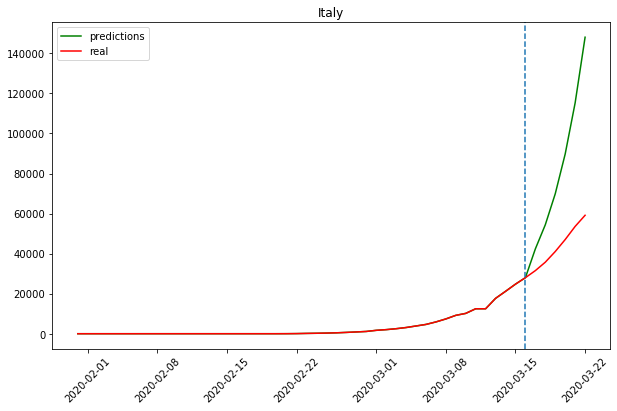

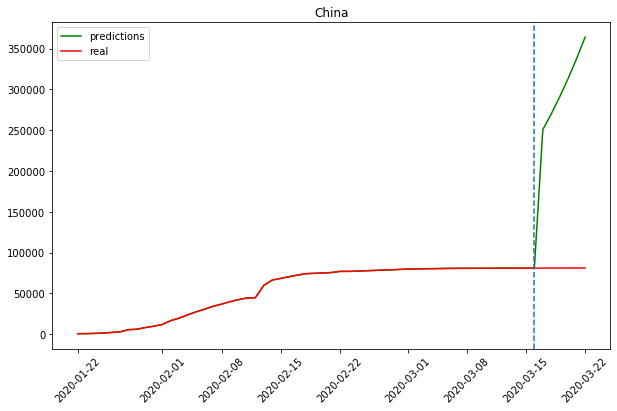

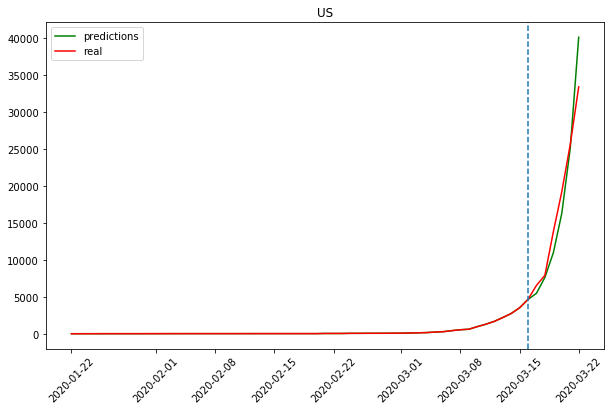

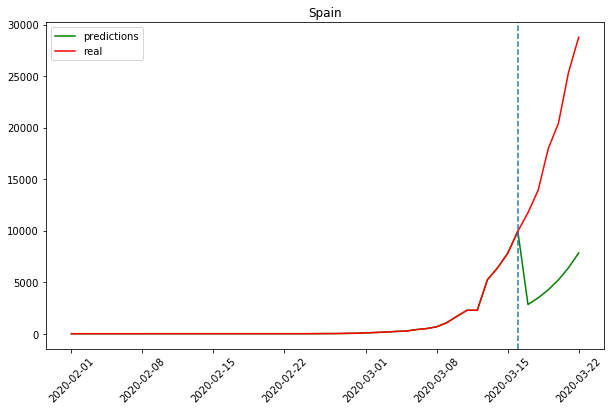

In [21]:
country_name=['Italy','China','US','Spain']
for name in country_name:
    dt2=dt_agg[dt_agg['country']==name]
    country_plot(dt2,name,x_size=10,y_size=6,save_fig=True)